<a href="https://colab.research.google.com/github/abhishekshakya/BPSO-and-ANN-for-sofware-fault-predicition/blob/master/internPSO_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
#https://ieeexplore.ieee.org/abstract/document/8011255
#from SVM https://www.youtube.com/watch?v=_PwhiWxHK8o

Mounted at /content/drive/


In [ ]:
# !pip install -U skorch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.io import arff
from sklearn.model_selection import cross_val_score
# from skorch import NeuralNetClassifier
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [3]:
pc1 = pd.read_csv('/content/drive/My Drive/dataset/PC1.csv')
kc1 = pd.read_csv('/content/drive/My Drive/dataset/KC1.csv')
kc3 = pd.read_csv('/content/drive/My Drive/dataset/KC3.csv')
jm1 = pd.read_csv('/content/drive/My Drive/dataset/JM1.csv')   

##Data cleaning

#####For kc2, here y feature is in object type

In [4]:
def output_red(df):
  p = df.iloc[:,-1]
  map = {'Y':True, 'N':False}
  df.iloc[:,-1] = p.map(map)
  return df

df_pc1 = output_red(pc1)
df_kc1 = output_red(kc1)
df_kc3 = output_red(kc3)
df_jm1 = output_red(jm1)


In [5]:
def normalize(x):
  x = x.astype(float)
  min = np.min(x)
  max = np.max(x)
  return (x - min)/(max-min)

####For jm1, we have '?' randomly distributed so we need to remove them also

In [6]:
def clean(df):
  for d in tqdm(range(len(df.iloc[0]))):
    i=0
    d1 = df.iloc[:,d]
    # print(type(d1))
    while i<len(d1):
      if (str)(d1.iloc[i]) == '?':
        # print(d1.iloc[i])
        df.drop(i,inplace=True)
      i += 1



In [7]:
print(f"initial shapes {df_kc3.shape} {df_kc1.shape} {df_jm1.shape} {df_pc1.shape}")
clean(df_kc3)
clean(df_kc1)
clean(df_jm1)
clean(df_pc1)
print(f"after shapes {df_kc3.shape} {df_kc1.shape} {df_jm1.shape} {df_pc1.shape}")

initial shapes (458, 41) (2107, 22) (10878, 22) (1107, 41)



after shapes (200, 41) (2107, 22) (10878, 22) (759, 41)


In [8]:
req_cols = df_kc1.columns
df_jm1.rename(columns = {'label':'Defective'}, inplace = True) 
df_jm1 = df_jm1[req_cols]
df_kc1 = df_kc1[req_cols]
df_kc3 = df_kc3[req_cols]
df_pc1 = df_pc1[req_cols]
print(df_kc1.columns)
print(df_kc3.columns)
print(df_pc1.columns)
print(df_jm1.columns)

Index(['LOC_BLANK', 'BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'CYCLOMATIC_COMPLEXITY', 'DESIGN_COMPLEXITY', 'ESSENTIAL_COMPLEXITY',
       'LOC_EXECUTABLE', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY',
       'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH',
       'HALSTEAD_LEVEL', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME',
       'NUM_OPERANDS', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS',
       'NUM_UNIQUE_OPERATORS', 'LOC_TOTAL', 'Defective'],
      dtype='object')
Index(['LOC_BLANK', 'BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'CYCLOMATIC_COMPLEXITY', 'DESIGN_COMPLEXITY', 'ESSENTIAL_COMPLEXITY',
       'LOC_EXECUTABLE', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY',
       'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH',
       'HALSTEAD_LEVEL', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME',
       'NUM_OPERANDS', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS',
       'NUM_UNIQUE_OPERATORS', 'LOC_TOTAL', 'Defective'],
      dtype='object')
Index(

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [10]:
class ANN(nn.Module):
  def __init__(self,features, nodes1, nodes2):
    super().__init__()
    self.l1 = nn.Linear(features, nodes1)
    self.l2 = nn.Linear(nodes1, nodes2)
    self.l3 = nn.Linear(nodes2 ,1)

  def forward(self,x):
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    x = (self.l3(x))
    return torch.sigmoid((x))

class network:
  def __init__(self, nodes1, nodes2, dim, r):
    """nodes = number of neural nodes in first layer
       dim = number of features
       r = learning rate
      """
    self.ANN = ANN(dim, nodes1, nodes2)
    self.optim = optim.Adam(self.ANN.parameters(), lr=r)
    self.criterion = nn.BCELoss()

  def fit(self, x, y, iterations):
    ANN = self.ANN
    optimizer = self.optim
    criterion = self.criterion
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    # y = y.reshape(y.shape[0],1)
    self.losses = []
    for i in (range(iterations)):

      optimizer.zero_grad()
    
      y_pred = ANN(x)
      y_pred = y_pred.squeeze()
      loss = criterion(y_pred, y)

      loss.backward()
      optimizer.step()
      self.losses.append(loss.item())
      # if i%((int)(iterations*0.05)) == 0:
      #   print(f"epoch {i}/{iterations}| loss=>{loss.item()}")
  
  def predict(self, x):
    ANN = self.ANN
    x = torch.from_numpy(x).float()
    y_ = ANN(x)
    y_ = y_.reshape(y_.shape[0])
    y_res = []
    for i in range(len(y_)):
      if y_[i] >= 0.5 :
        y_res.append(1)
      else:
        y_res.append(0)
    return y_res,y_.detach().cpu().numpy()

In [11]:
class PSO:
  def __init__(self,particles, dimensions, lb, ub, itrations, c1, c2, w, xr, yr, node1, node2, lr, epochs):
    self.node1 = node1
    self.node2 = node2
    self.lr = lr
    self.epochs = epochs
    
    self.xr = xr
    self.yr = yr
    self.lb = lb
    self.ub = ub
    self.p = particles
    self.d = dimensions
    self.n = itrations
    self.c1 = c1
    self.c2 = c2
    self.w = w
    self.fitness_value = np.zeros(particles)#p
    self.X = np.random.randint(2,size=(particles,dimensions))#pxd
    self.V = np.random.randint(2,size=(particles,dimensions))#pxd
    self.pbest = self.X#pxd
    self.gbest = np.zeros(dimensions)#d
    max = 0
    self.maxg = 0
    self.run()

  def sigmoid(self,x):
    return 1/(1+np.exp(-x))
  
  def count(self,x):
    c = np.sum(x)
    return c

  def fitness(self,x):
    x_train = []
    y_train = self.yr

    for i in range(self.d):
      if x[i] == 1:
        x_train.append(self.xr[:,i])

    x_train = np.array(x_train).reshape((self.xr.shape[0],-1))

    if x_train.shape[1] == 0:#no feature selected then return 0 acc
      return 0
    #Stratified K Fold cross Validation-----------------------------------------------
    kfold =StratifiedKFold(n_splits=10)
    cc = 0
    accs = []
    for train_index, test_index in kfold.split(x_train, y_train):
      cc += 1
      x_train_fold = x_train[train_index] 
      y_train_fold = y_train[train_index] 
      x_test_fold = x_train[test_index] 
      y_test_fold = y_train[test_index]
      # neural Networks --------------overfitting----------------
      # net = network(self.node1,self.node2, x_train_fold.shape[1], self.lr)
      # net.fit(x_train_fold, y_train_fold, self.epochs)
      # ans,_ = net.predict(x_test_fold)
      #----------------------------------------------------------
      #---------KNN----------------------------------------------
      clf = KNeighborsClassifier(2)
      clf.fit(x_train_fold, y_train_fold)
      ans = clf.predict(x_test_fold)
      #-------------------------------------------------------------

      acc = ((ans==y_test_fold).sum()*1.0)/len(ans)
      accs.append(acc)

    return np.array(accs).mean()

  def run(self):
    for itr in tqdm(range(self.n)):
      if itr%5 == 0:
        print(f"iterations {itr} | max acc achieved {self.maxg} using {self.count(self.gbest)} features")
      for i in range(self.p):
        fit = self.fitness(self.X[i])
        if fit > self.fitness_value[i]:
          self.pbest[i] = np.copy(self.X[i])
          self.fitness_value[i] = fit

        if fit > self.maxg:
          self.gbest = np.copy(self.X[i])
          self.maxg = fit

        if fit == self.maxg and (self.count(self.X[i]) < self.count(self.gbest)):
          self.gbest = np.copy(self.X[i])

      for p in range(self.p):
        for q in range(self.d):
          r1 = np.random.randn()
          r2 = np.random.randn()
          self.V[p][q] = self.w * self.V[p][q] + self.c1*r1*(self.pbest[p][q] - self.X[p][q]) + self.c2*r2*(self.gbest[q] - self.X[p][q])

          if self.V[p][q] > self.ub:
            self.V[p][q] = self.ub
          if self.V[p][q] < self.lb:
            self.V[p][q] = self.lb

          if self.sigmoid(self.V[p][q]) > np.random.uniform(0,1):
            self.X[p][q] = 1
          else:
            self.X[p][q] = 0

      if fit == 1.0: #stop when acc is 100
          return
        


In [12]:
def get(p, lb, ub, it, c1, c2, w, node1, node2, lr, epochs, df):
  x = df.iloc[:,:-1].apply(func= normalize, axis=0).values
  y = df.iloc[:,-1].values.astype(int)

  pp = PSO(p,x.shape[1],lb,ub,it,c1,c2,w, x, y,node1,node2,lr,epochs)

  return pp

def ROC_curve(df,node1, node2, lr, epochs, name, pp):
  x = df.iloc[:,:-1].apply(func= normalize, axis=0).values
  y = df.iloc[:,-1].values.astype(int)

  # #------------------------------------------------ROC curve---------------------------------------
  print(f"for {name}")
  print(f"selected metrics :")
  cols = []
  for i in range(len(pp.gbest)):
    if pp.gbest[i] == 1:
      cols.append(df.columns[i])
  
  print(f"number of features selected {len(cols)}")
  print(cols)
  res = df[cols]
  
  x_ruc = res.apply(func= normalize, axis = 0).values
  # print(x_ruc)

  kfold =StratifiedKFold(n_splits=10, shuffle=True)
  cc = 0
  aucs = []
  for train_index, test_index in kfold.split(x_ruc, y):
      cc += 1
      x_train_fold = x_ruc[train_index] 
      y_train_fold = y[train_index] 
      x_test_fold = x_ruc[test_index] 
      y_test_fold = y[test_index]

      net = network(node1,node2, x_train_fold.shape[1], lr)
      net.fit(x_train_fold, y_train_fold, epochs)
      prediction2, y2_prob = net.predict(x_test_fold) 
      # print(f"accuracy->{100*(((prediction2==y).sum()*1.0)/len(y))}")
      # print(y2_prob)
      # print(x_train_fold.shape, y_train_fold.shape,y2_prob.shape)

      # clf = SVC(probability=True)
      # clf.fit(x_train_fold, y_train_fold)
      # y2_prob = clf.predict_proba(x_test_fold)

      fpr, tpr, _= metrics.roc_curve(y_test_fold,y2_prob)
      auc = metrics.roc_auc_score(y_test_fold,y2_prob)
      fig,a = plt.subplots(1,2,figsize=(12,4))

      a[0].set_title("ROC")
      a[0].plot(fpr,tpr,label='auc: '+str(auc))
      a[0].legend(loc=4)
      a[1].set_title("Erorr Loss")
      a[1].plot(net.losses)
      plt.show()

      aucs.append(auc)
      #-------------------------------------------------------------
      # print(ans)
      # acc = ((ans==y_test_fold).sum()*1.0)/len(ans)
      # loss = metrics.log_loss(y_test_fold,  ans[:,1])
      # accs.append(loss)
  print(f"max AUC score of 10 k-Fold {max(aucs)}")


In [13]:
p = 60 #number of particles
lb = -1 #min value for velocity 
ub = 1 #max value for velocity 
it = 100 #number of itrations
c1 = 2 # coefficient 1
c2 = 2 # coefficient 3
w = 0.4 #inertia

node1 = 4 #total number of nodes in layer1
node2 = 2 #total number of nodes in layer2
lr = 0.0016 #learning rate
epochs = 50 #epochs in ANN
pso = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_pc1)

iterations 0 | max acc achieved 0 using 0.0 features
iterations 5 | max acc achieved 0.9209473684210527 using 11 features
iterations 10 | max acc achieved 0.9209473684210527 using 11 features
iterations 15 | max acc achieved 0.9222631578947368 using 11 features
iterations 20 | max acc achieved 0.9222631578947368 using 11 features
iterations 25 | max acc achieved 0.9235789473684208 using 11 features
iterations 30 | max acc achieved 0.9235789473684208 using 11 features
iterations 35 | max acc achieved 0.9235789473684208 using 11 features
iterations 40 | max acc achieved 0.9235789473684208 using 11 features
iterations 45 | max acc achieved 0.9235789473684208 using 11 features
iterations 50 | max acc achieved 0.9235789473684208 using 11 features
iterations 55 | max acc achieved 0.9235789473684208 using 11 features
iterations 60 | max acc achieved 0.9235789473684208 using 11 features
iterations 65 | max acc achieved 0.9235789473684208 using 11 features
iterations 70 | max acc achieved 0.923

for pc1
selected metrics :
number of features selected 11
['LOC_BLANK', 'BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'CYCLOMATIC_COMPLEXITY', 'DESIGN_COMPLEXITY', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'NUM_UNIQUE_OPERATORS']


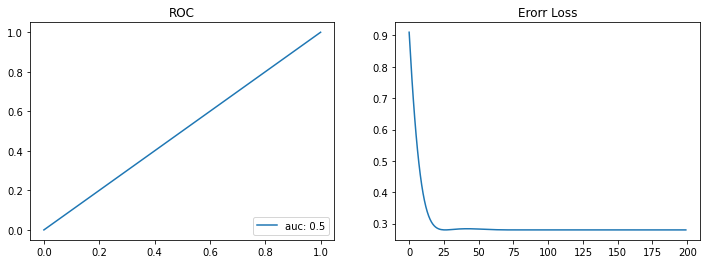

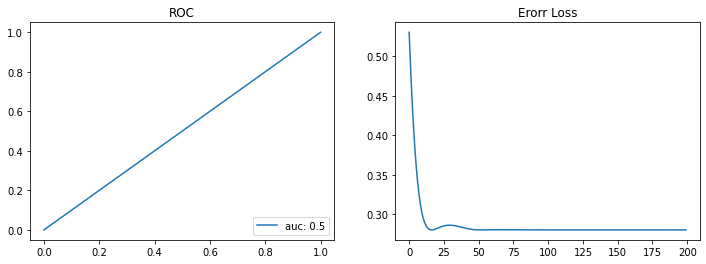

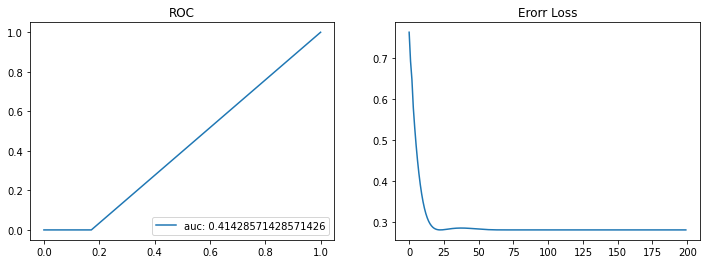

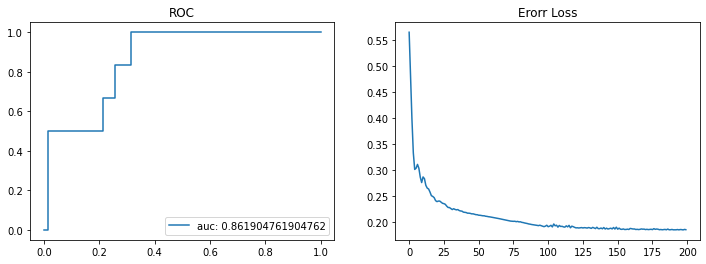

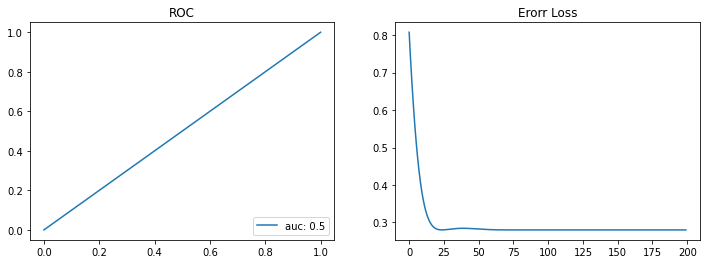

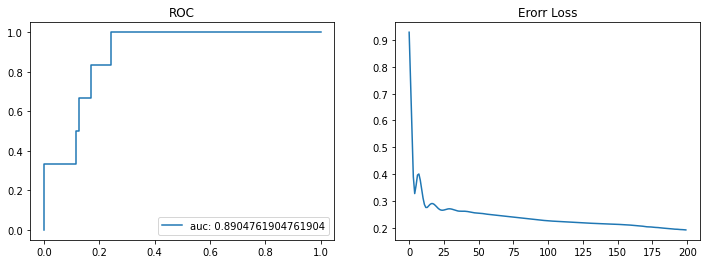

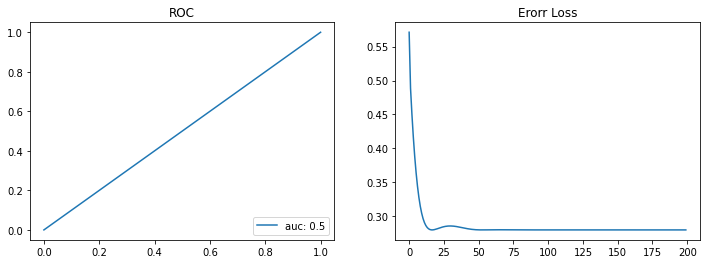

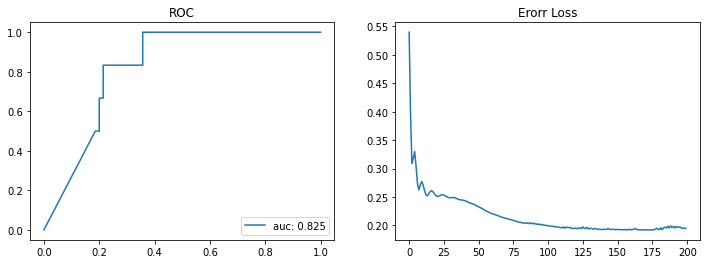

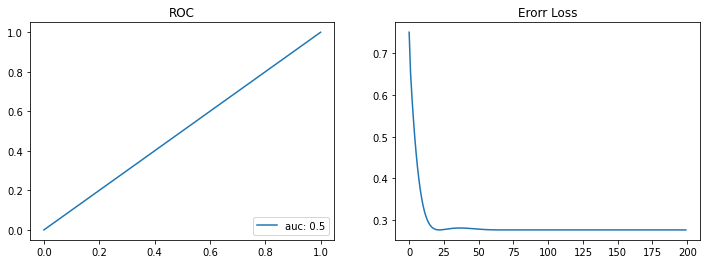

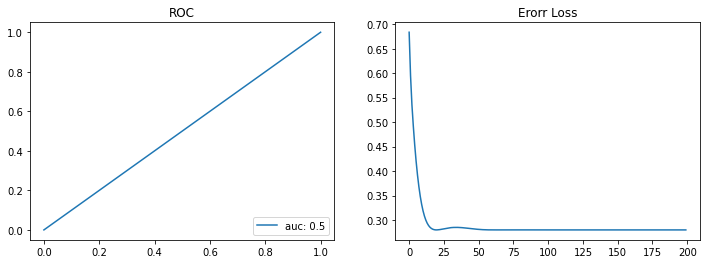

max AUC score of 10 k-Fold 0.8904761904761904


In [16]:
ROC_curve(df_pc1, 8, 2, 0.15, 200,"pc1",pso)

In [17]:
pso2 = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_kc1)

iterations 0 | max acc achieved 0 using 0.0 features
iterations 5 | max acc achieved 0.8391130670277589 using 10 features
iterations 10 | max acc achieved 0.8414827352742045 using 13 features
iterations 15 | max acc achieved 0.8414827352742045 using 13 features
iterations 20 | max acc achieved 0.8414827352742045 using 13 features
iterations 25 | max acc achieved 0.8414827352742045 using 13 features
iterations 30 | max acc achieved 0.8414827352742045 using 13 features
iterations 35 | max acc achieved 0.8414827352742045 using 13 features
iterations 40 | max acc achieved 0.8414849921011058 using 13 features
iterations 45 | max acc achieved 0.8414849921011058 using 13 features
iterations 50 | max acc achieved 0.8414849921011058 using 13 features
iterations 55 | max acc achieved 0.8414849921011058 using 13 features
iterations 60 | max acc achieved 0.8419498984427893 using 11 features
iterations 65 | max acc achieved 0.8419498984427893 using 11 features
iterations 70 | max acc achieved 0.841

for kc1
selected metrics :
number of features selected 9
['LOC_BLANK', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS', 'ESSENTIAL_COMPLEXITY', 'LOC_EXECUTABLE', 'HALSTEAD_CONTENT', 'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH']


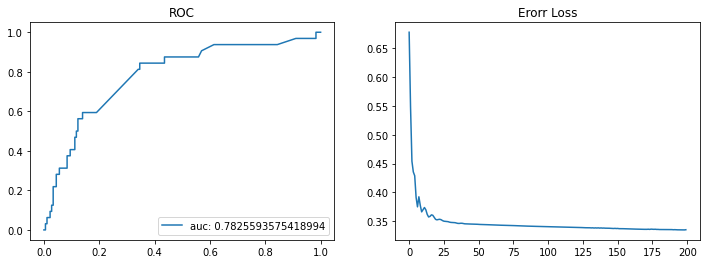

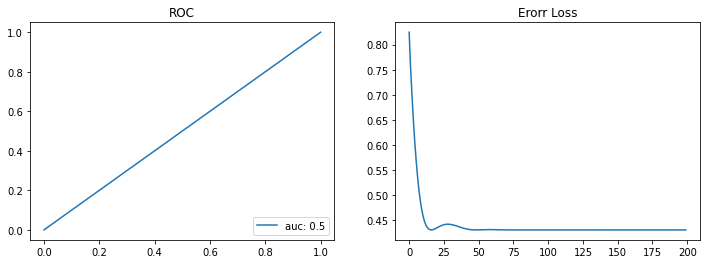

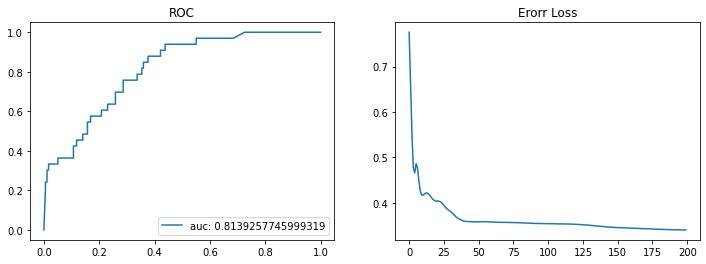

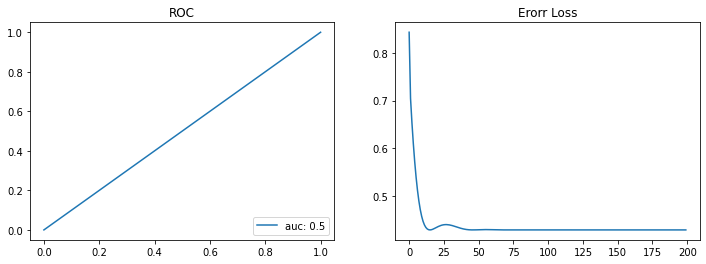

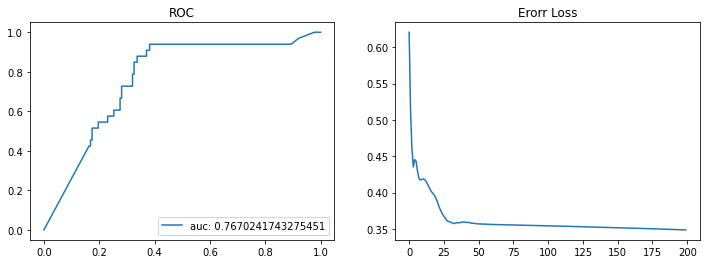

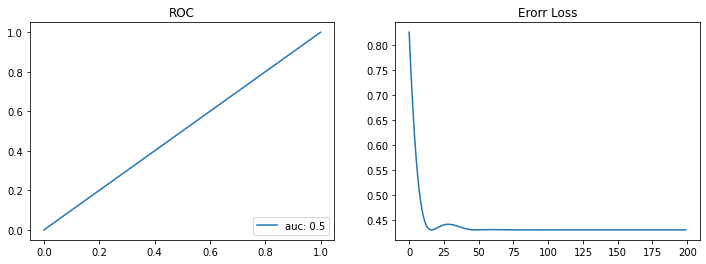

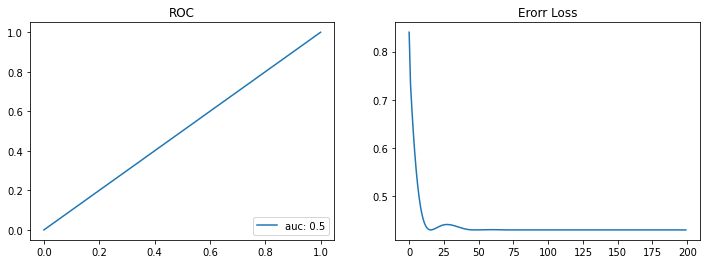

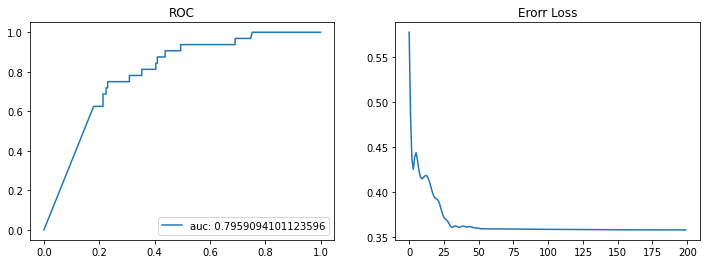

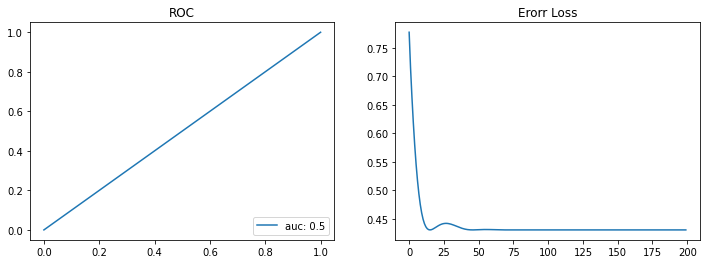

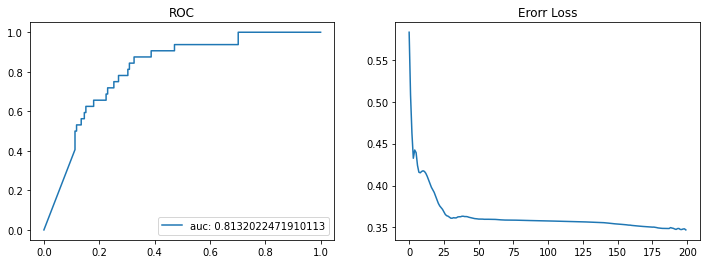

max AUC score of 10 k-Fold 0.8139257745999319


In [21]:
ROC_curve(df_kc1, 8, 2, 0.15, 200,"kc1",pso2)

In [19]:
pso3 = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_kc3)

iterations 0 | max acc achieved 0 using 0.0 features
iterations 5 | max acc achieved 0.835 using 11 features
iterations 10 | max acc achieved 0.8350000000000002 using 11 features
iterations 15 | max acc achieved 0.8400000000000001 using 7 features
iterations 20 | max acc achieved 0.8400000000000001 using 7 features
iterations 25 | max acc achieved 0.8400000000000001 using 7 features
iterations 30 | max acc achieved 0.8400000000000001 using 7 features
iterations 35 | max acc achieved 0.8400000000000001 using 7 features
iterations 40 | max acc achieved 0.8400000000000001 using 7 features
iterations 45 | max acc achieved 0.8400000000000001 using 7 features
iterations 50 | max acc achieved 0.8400000000000001 using 7 features
iterations 55 | max acc achieved 0.8400000000000001 using 7 features
iterations 60 | max acc achieved 0.8400000000000001 using 7 features
iterations 65 | max acc achieved 0.8400000000000001 using 7 features
iterations 70 | max acc achieved 0.8450000000000001 using 10 f

for kc3
selected metrics :
number of features selected 10
['LOC_BLANK', 'BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS', 'CYCLOMATIC_COMPLEXITY', 'DESIGN_COMPLEXITY', 'ESSENTIAL_COMPLEXITY', 'LOC_EXECUTABLE', 'HALSTEAD_LEVEL', 'NUM_UNIQUE_OPERATORS']


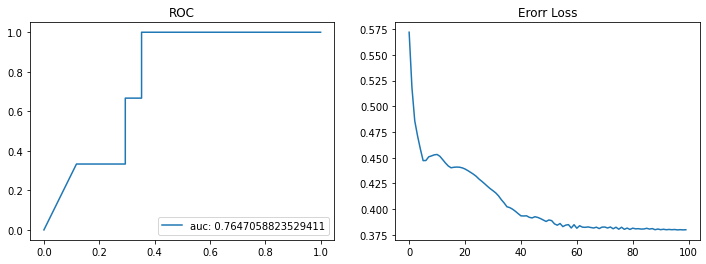

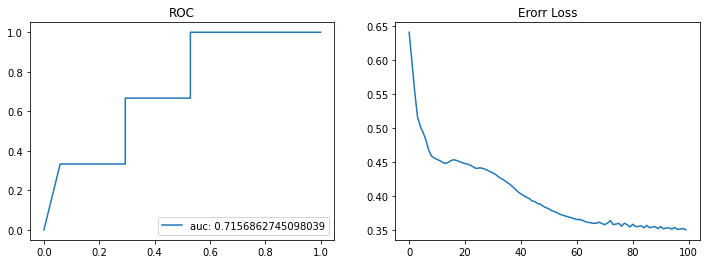

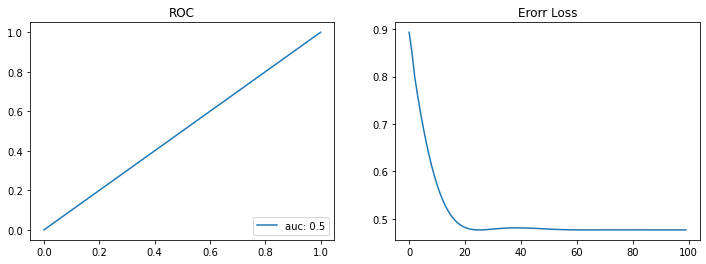

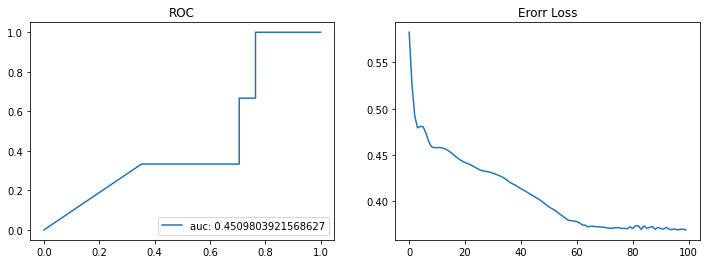

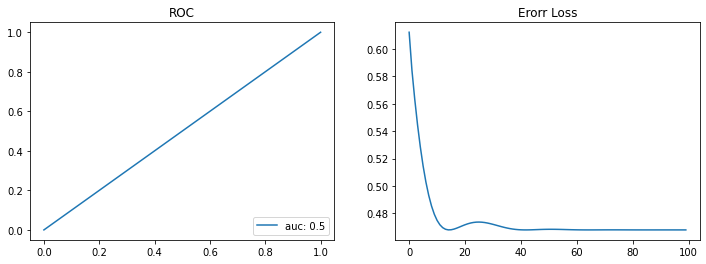

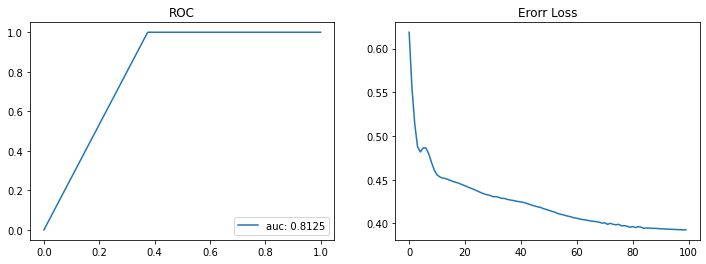

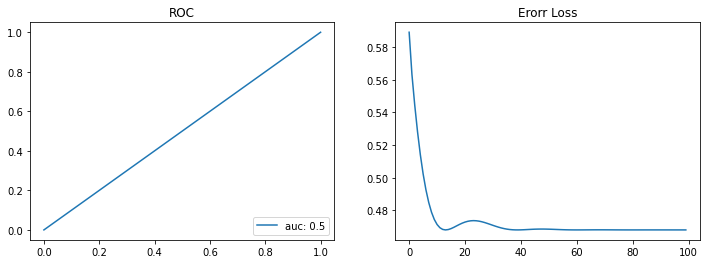

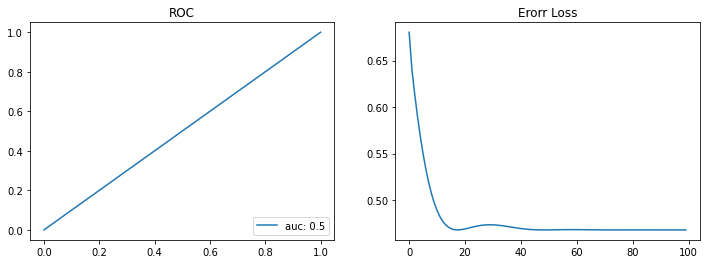

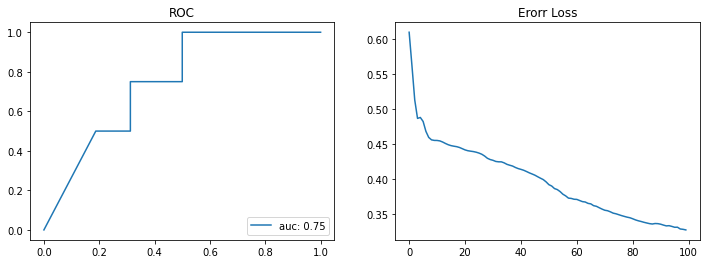

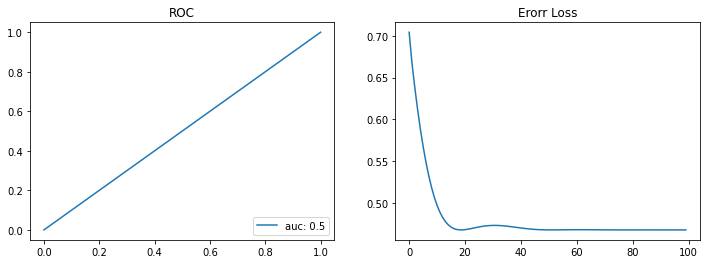

max AUC score of 10 k-Fold 0.8125


In [31]:
ROC_curve(df_kc3, 8, 2, 0.10, 100,"kc3",pso3)

In [24]:
pso4 = get(p,lb,ub,it,c1,c2,w,node1,node2,lr,epochs,df_jm1)

iterations 0 | max acc achieved 0 using 0.0 features
iterations 5 | max acc achieved 0.8514371042805348 using 11 features
iterations 10 | max acc achieved 0.8871847773147898 using 6 features
iterations 15 | max acc achieved 0.8899420457005249 using 6 features
iterations 20 | max acc achieved 0.8939881926781752 using 6 features
iterations 25 | max acc achieved 0.8939881926781752 using 6 features
iterations 30 | max acc achieved 0.8939881926781752 using 6 features
iterations 35 | max acc achieved 0.8939881926781752 using 6 features
iterations 40 | max acc achieved 0.8939881926781752 using 6 features
iterations 45 | max acc achieved 0.895184483061854 using 6 features
iterations 50 | max acc achieved 0.895184483061854 using 6 features
iterations 55 | max acc achieved 0.895184483061854 using 6 features
iterations 60 | max acc achieved 0.895184483061854 using 6 features
iterations 65 | max acc achieved 0.895184483061854 using 6 features
iterations 70 | max acc achieved 0.895184483061854 usin

for jm1
selected metrics :
number of features selected 6
['LOC_CODE_AND_COMMENT', 'CYCLOMATIC_COMPLEXITY', 'HALSTEAD_CONTENT', 'HALSTEAD_LEVEL', 'HALSTEAD_PROG_TIME', 'LOC_TOTAL']


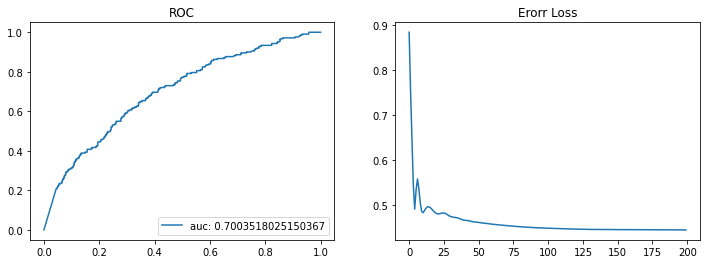

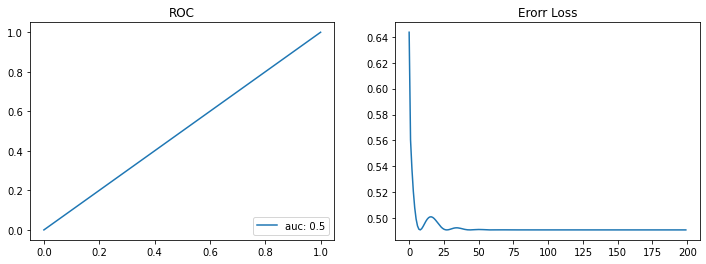

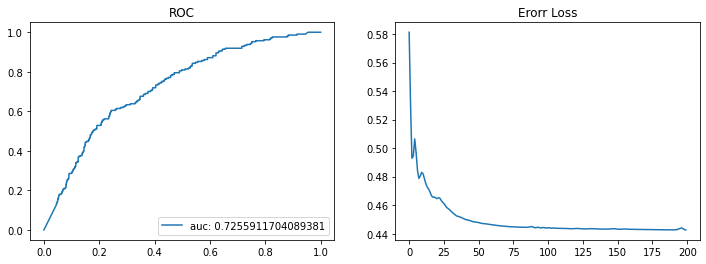

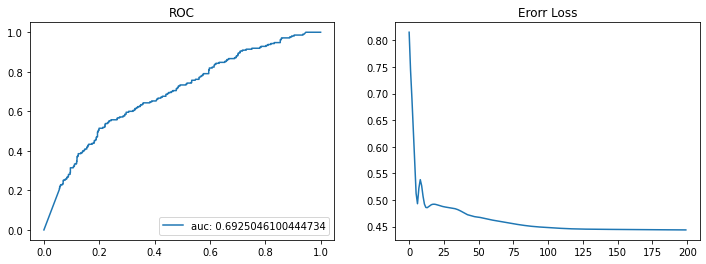

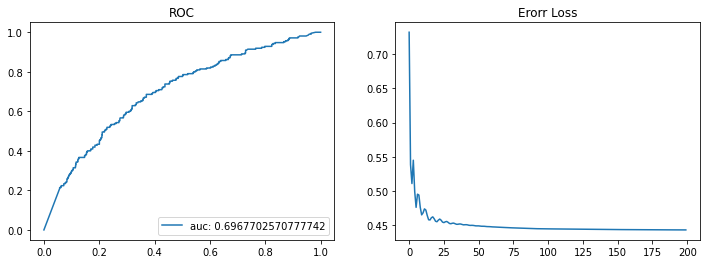

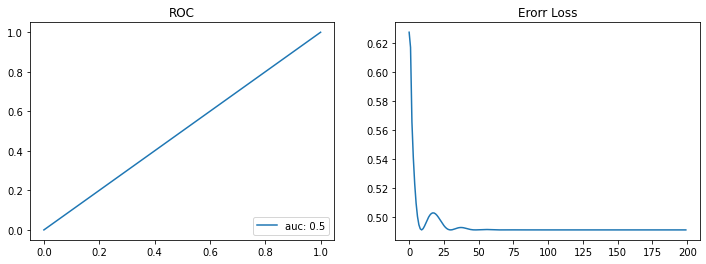

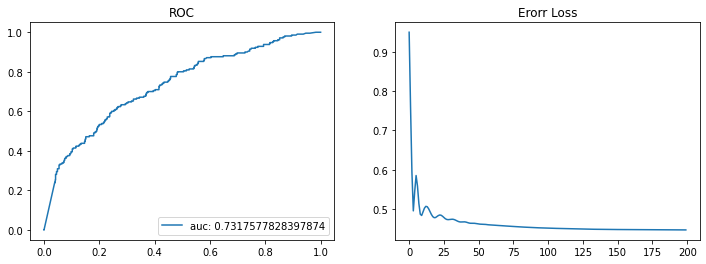

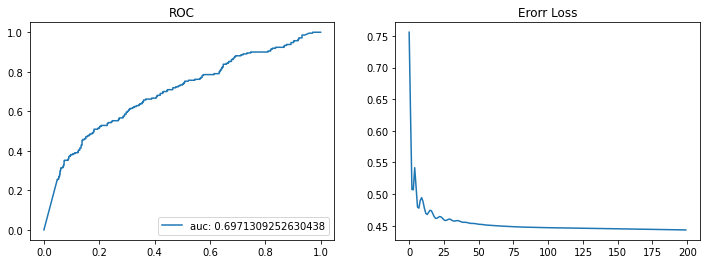

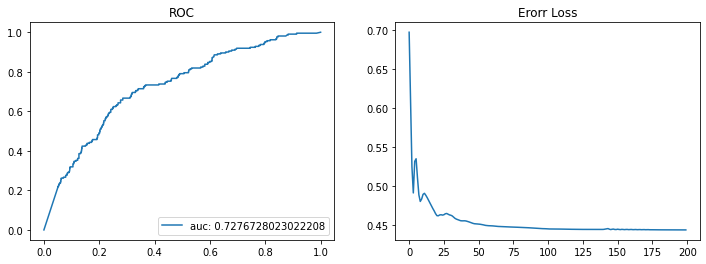

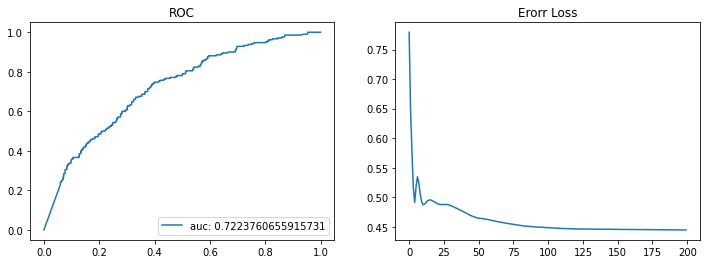

max AUC score of 10 k-Fold 0.7317577828397874


In [25]:
ROC_curve(df_jm1, 8, 2, 0.15, 200,"jm1",pso4) 